<a href="https://colab.research.google.com/github/paarthbamb/CyberPatriotStuff/blob/main/Unit5/Copy_of_PaarBambUnit5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import graphviz as gv

from scipy.interpolate import PchipInterpolator

# **Unit 5 Project: How does "hype" affect sneaker resell prices?**
by Paarth Bamb

**Part I: Context**




In the world of sneaker reselling, the amount of popularity a certain release has greatly affects its value on aftermarket platforms. Since I have direct experience with sneaker reselling, this dataset fits both my personal interests and the GLM structure. In this project, I will use the "hype index" of a release out of 100 (measured using various factors which help determine popularity) to predict the resale price of 200 recent sneaker releases.

**Part II: Data**

In [3]:
sneaker_data = pd.read_csv('https://raw.githubusercontent.com/paarthbamb/dataScience/refs/heads/main/Unit5/sneaker_resell_dataset.csv')
sneaker_data

,resale_price,hype_index,retail_price,release_volume
0,81.14,19.40,111.89,16339
1,68.58,12.27,145.57,40178
2,172.53,49.75,144.23,26150
3,120.39,35.82,165.76,44697
4,77.76,12.55,120.65,6703
...,...,...,...,...
195,228.67,70.58,119.60,60650
196,87.65,5.90,149.01,53733
197,144.69,29.08,128.91,63430
198,54.98,0.21,153.11,19544


In [4]:
sneaker_data.columns

Index(['resale_price', 'hype_index', 'retail_price', 'release_volume'], dtype='object')

<Axes: xlabel='hype_index', ylabel='resale_price'>

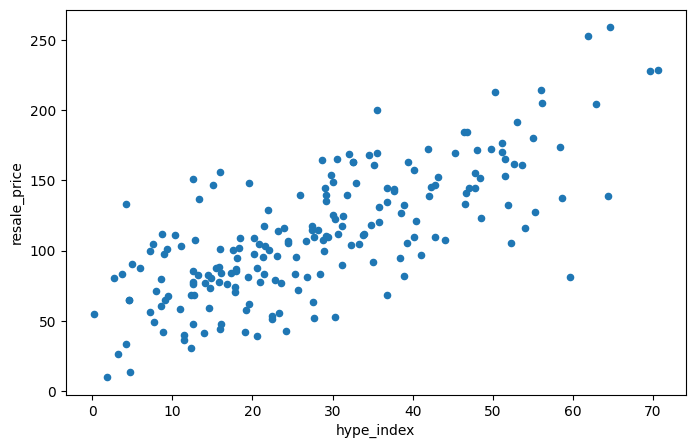

In [5]:
sneaker_data.plot(x="hype_index", y = "resale_price", figsize=(8, 5) , kind="scatter")

There seems to be a somewhat linear relationship here, so let's proceed.

**Part III: Model**

In [ ]:
import pymc as pm

with pm.Model() as nh_model:
    #priors
    α = pm.Normal("α", mu=0, sigma=5)
    β = pm.HalfNormal("β", sigma=10)
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α + β * sneaker_data['hype_index'],
                  sigma=σ,
                  observed=sneaker_data['resale_price'])
    idata_nh_b = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_nh_b, model=nh_model,  extend_inferencedata=True)

Text(0, 0.5, 'Resale Price')

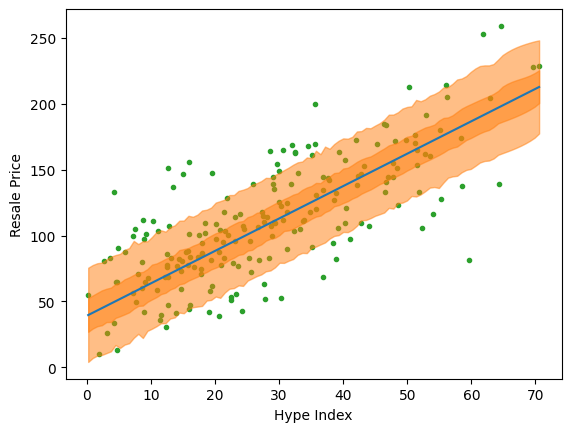

In [8]:
experience_values = sneaker_data['hype_index'].values
idx = np.argsort(experience_values)
x = np.linspace(experience_values.min(), experience_values.max(), 100) # 100 points for a smooth line

alpha_posterior = idata_nh_b.posterior["α"]
beta_posterior = idata_nh_b.posterior["β"]
mu_posterior_pred = alpha_posterior.values[:, :, None] + beta_posterior.values[:, :, None] * x[None, None, :]

mean_line = np.mean(mu_posterior_pred, axis=(0, 1))

y_pred_q = idata_nh_b.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

y_hat_bounds_list = []
for i in range(4):
    combined_data = pd.DataFrame({
        'x_val': experience_values[idx],
        'y_val': y_pred_q[i].values[idx]
    }).groupby('x_val').mean().reset_index()

    interpolator = PchipInterpolator(combined_data['x_val'], combined_data['y_val'])
    y_hat_bounds_list.append(interpolator(x))

y_hat_bounds = iter(y_hat_bounds_list)

_, ax = plt.subplots()
ax.plot(sneaker_data['hype_index'], sneaker_data['resale_price'], "C2.", zorder=-3)
ax.plot(x, mean_line, c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("Hype Index")
ax.set_ylabel("Resale Price")

This shows a linear relationship as there is a clear slope to the correlation.

In [ ]:
pm.sample_posterior_predictive(idata_nh_b, model=nh_model,  extend_inferencedata=True)

<Axes: xlabel='y_pred'>

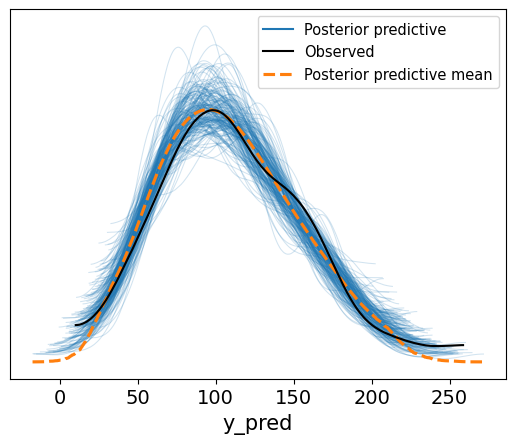

In [10]:
az.plot_ppc(idata_nh_b, num_pp_samples=200)


The posterior predictive check shows that the observed is pretty well modeled by the GLM, which means we are done!

From my experience, this model does represent reality. What the model is saying is that as more and more people become aware of and talk about a certain pair of sneakers, the price the pair will fetch on the resale market increases. This is true because resale price is essentially a function of the aesthetics of the shoe and the popularity, and since a better looking shoe would likely be more popular, this model makes sense.